# Modelling of the data

In [200]:
fishes <- read.csv("input/finresoct.csv")
str(fishes)
fishes <- subset(fishes, info != 'error') # remove data where we made experimental mistakes
fishes$abs10prev <-abs(fishes$stable10prev)
fishes$abs10post <-abs(fishes$stable10after)

## now trying to plot histogram of outcomes...
unique(fishes$info)
#
#boxplot(table(fishes$info))
#library(ggplot2)
#ggp <- ggplot(data.frame(fishes$info),aes(x=fishes$info))
#ggp + geom_histogram(fill="lightgreen")
#ggp + geom_histogram(fill="lightblue",aes(y=..count../sum(..count..)))


'data.frame':	141 obs. of  36 variables:
 $ fishname      : chr  "fish58" "fish59" "fish60" "fish64" ...
 $ fs            : chr  "low" "low" "low" "low" ...
 $ fishdate      : chr  "13Mar" "13Mar" "13Mar" "13Mar" ...
 $ time_flow     : chr  "15:17:32" "15:45:57" "16:13:24" "18:07:33" ...
 $ time_react    : chr  "-" "-" "-" "-" ...
 $ tdiff         : chr  "nan" "nan" "nan" "nan" ...
 $ info          : chr  "unstable" "unstable" "unstable" "unstable" ...
 $ info_other    : chr  "" "" "" "" ...
 $ direction     : chr  "counter" "clock" "counter" "counter" ...
 $ stable10prev  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ change10      : num  NA NA NA NA NA NA NA NA NA NA ...
 $ stable10after : num  NA NA NA NA NA NA NA NA NA NA ...
 $ fishtype      : chr  "farmed_loch" "farmed_loch" "farmed_loch" "farmed_loch" ...
 $ loc_name      : chr  "" "" "" "" ...
 $ loc_x         : num  NA NA NA NA NA NA NA NA NA NA ...
 $ loc_y         : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Unnamed..3    : logi

[1] "unstable"    "no_reaction" "dir_change"  "swim_off"

[1] 12.635

[1] 5.356299

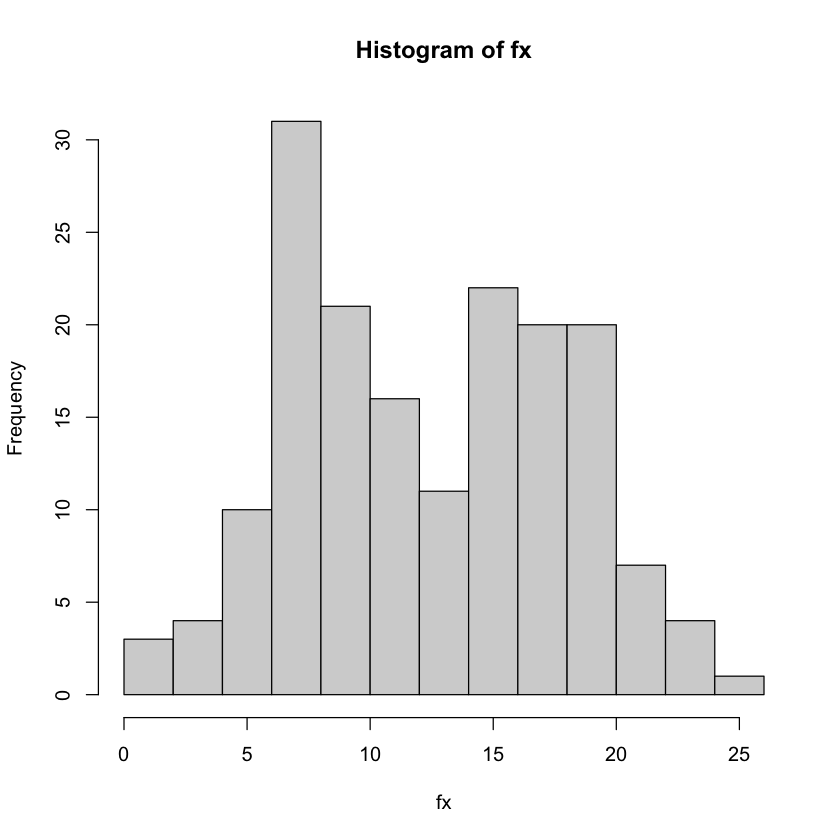

In [205]:
#What were the flow condition at the point where fish has been holding.
#average of all measurements before and after
flowpre <- subset(fishes, !is.na(abs10prev))
flowpost <- subset(fishes, !is.na(abs10post))
fx <- c(flowpre$abs10prev, flowpost$abs10post)

mean(fx)
sd(fx)
hist(fx)
#the distribution is really bimodal, interesting?

# Question 1: What is the behaviour response of salmon smolts to switching current?

As you can see we are defining a success as dir_change, no_reaction as a failure and if fish is unstable or swims off, it is ambivalent (dk == don't known). 

We were able to judge reaction in 86 fish (64% of collected data points).
Out of those 86 fish, 62 changed direction (72%)

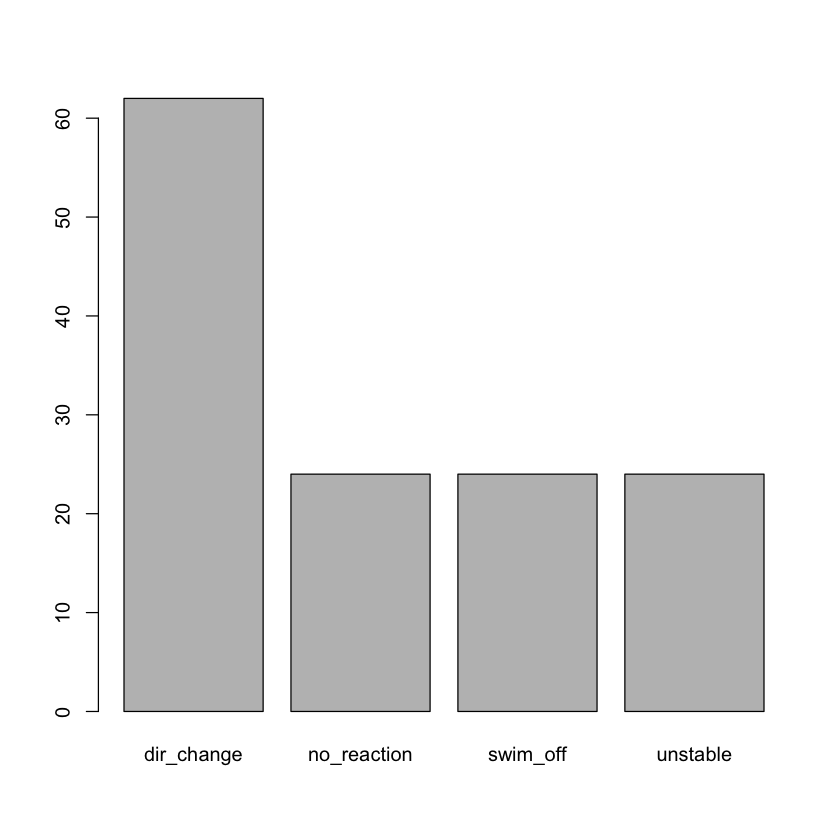

In [206]:
plot(factor(fishes$info))

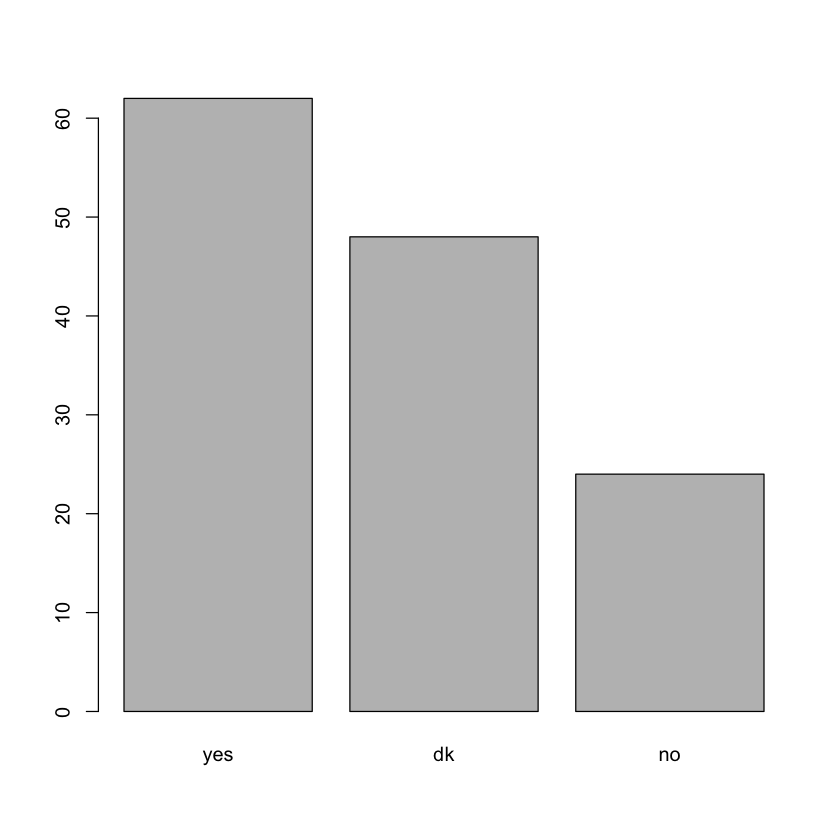

In [207]:
#swim_off and unstable are unknown/dk
fishes$success <- relevel(factor(fishes$success), "yes")
plot(factor(fishes$success))


In [208]:
dplyr::count(fishes, success, sort = TRUE)
#modelreacted <- glm(factor(fishesknown$success) ~ 1,family='binomial') #modelling here doesn't make much sense.
#summary(modelreacted)


success,n
<fct>,<int>
yes,62
dk,48
no,24


# Question 2: Does the response differ between fish types and flow conditions?

no

Warning message:
“Removed 24 rows containing non-finite values (stat_density).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 24 rows containing missing values”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message:
“Removed 24 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 24 rows containing missing values (geom_point).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 24 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



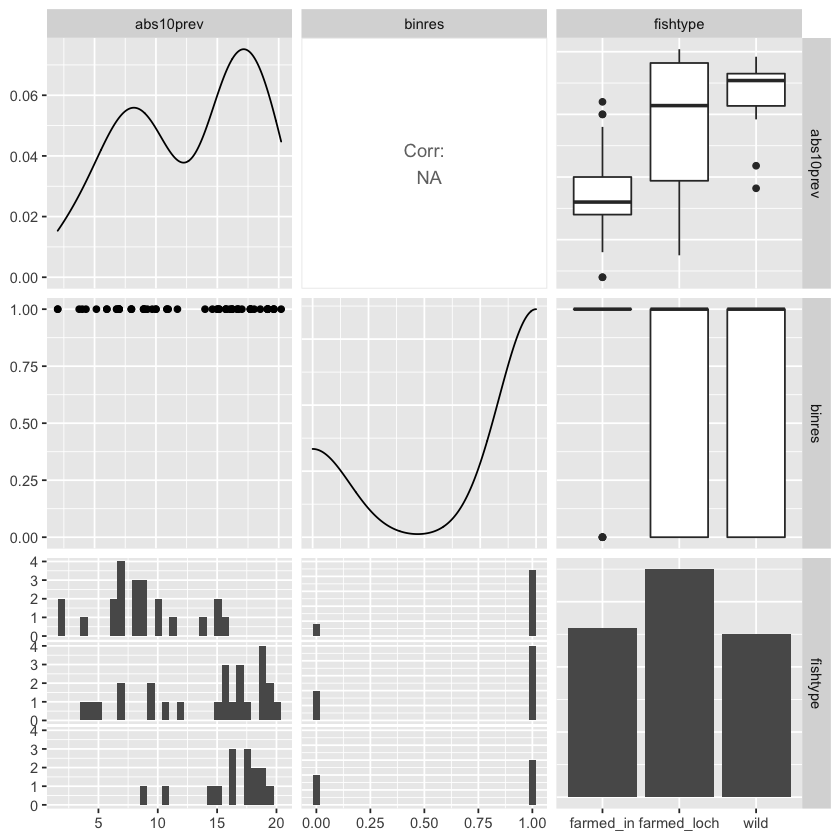

In [212]:
library(lme4)
library(GGally)

fishesknown <- subset(fishes, success != 'dk')

issuc <- function(x) {
  if (x == 'yes') {
    1
  } else {
    0
  }
}


#prepare binary vector for success
fishesknown$binres <- sapply(fishesknown$success, issuc) # might not be necessary


ggpairs(fishesknown[, c("abs10prev", "binres", "fishtype")])

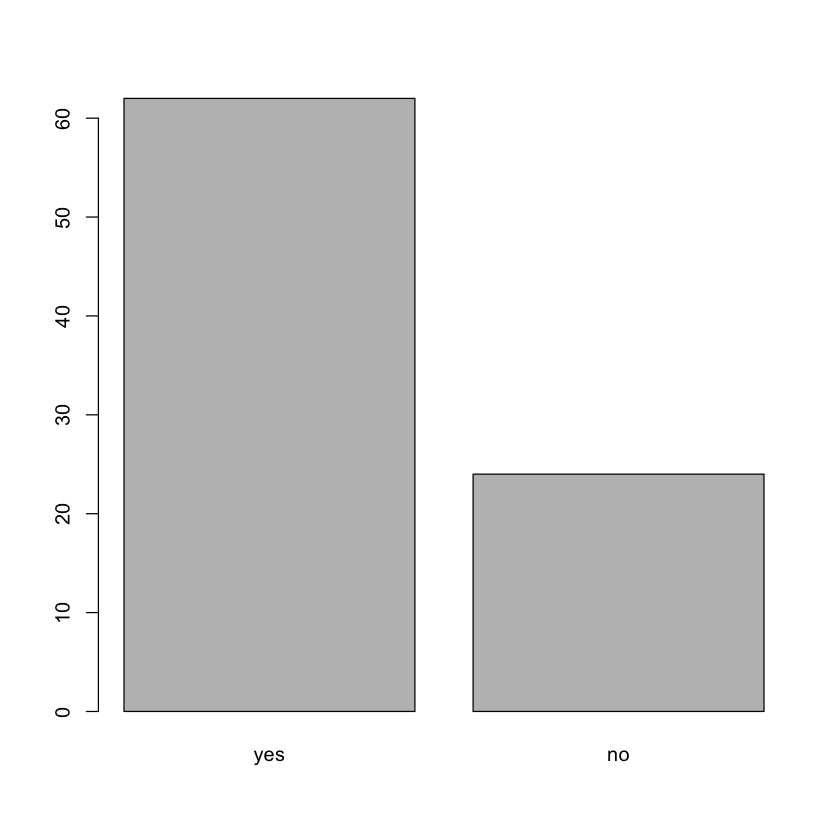

In [213]:
plot(factor(fishesknown$success))

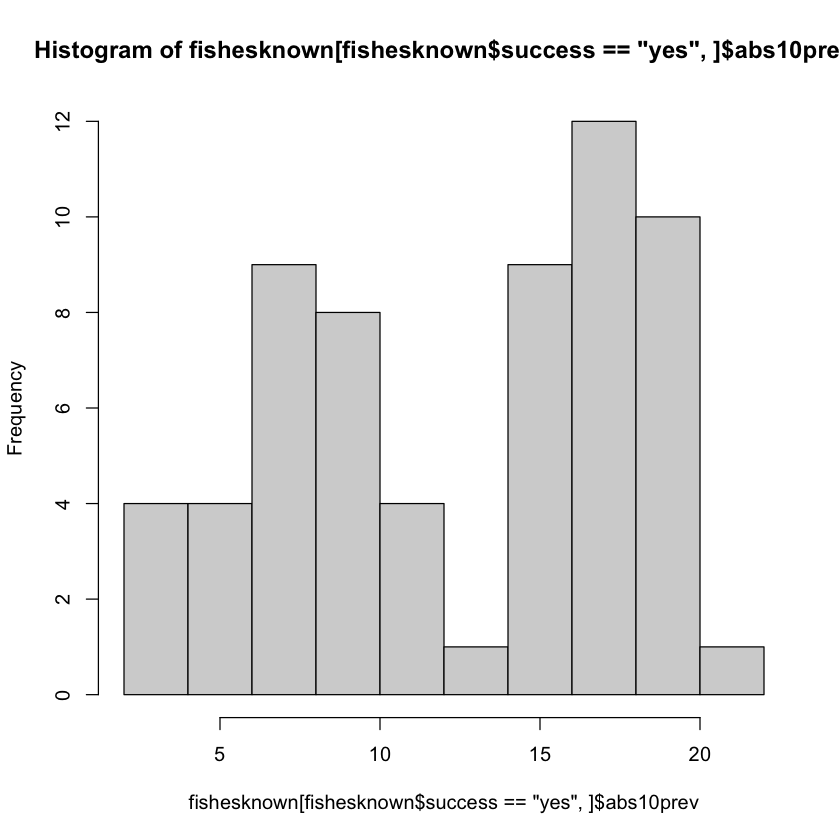

In [215]:
hist(fishesknown[fishesknown$success=='yes',]$abs10prev)
#hist(fishesknown[fishesknown$success=='no',]$abs10prev) 
#We don't have data on the strenght of the flow at the point of holding for the
#fish that was not successfull.... what a bummer. I mean it is quite obvious

In [223]:
#modelmixedflow<- glmer(success ~ fishtype + (1 | abs10prev),fishesknown,family='binomial')
#summary(modelmixedflow)

#the above produces some impossible to trace error, 
#but lets skip it for now and model previous flow as a fixed effect instead
#UPDATE: this is because we don't have the flow for all...!

modelreacted1 <- glm(binres ~ 1,fishesknown,family='binomial') 
modelreacted2 <- glm(binres ~ fishtype,fishesknown,family='binomial') 

#The following might be a way to compensating for different flow but because it is not really independent 
#it wont work. Anova tells us there is no point ofc
modelreacted5 <- glm(binres ~ fishtype * fsdir,fishesknown,family='binomial') 
modelreacted6 <- glm(binres ~ fsdir,fishesknown,family='binomial') 


#The following are not possible as we don't have abs10prev for unsuccessfull phish:
#modelreacted3 <- glm(binres ~ fishtype * abs10prev,fishesknown,family='binomial') 
#modelreacted4 <- glm(binres ~ abs10prev,fishesknown,family='binomial') 
#summary(modelreacted4)
#summary(modelreacted3)
#summary(modelreacted2)$coefficients[,1]
#summary(modelreacted2)

#summary(modelreacted2)$coefficients[,1]
#summary(modelreacted1)
#modelreacted1$family$linkinv(summary(modelreacted2)$coefficients[,1])

#summary(modelreacted5)

anova(modelreacted2, test="LRT") # Testing if fishtype is a significant component of our wee model


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,85,101.83649,NA
fishtype,2,3.982236,83,97.85425,0.1365427


In [224]:
summary(modelreacted2) #*IF* we found that it is significant (anova/an-dev) to include fishtype
#we could argue that fishtype-wild is ALMOST significant
#so it isn't :)


Call:
glm(formula = binres ~ fishtype, family = "binomial", data = fishesknown)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9348  -1.3537   0.5780   0.8203   1.0108  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)   
(Intercept)           1.7047     0.5436   3.136  0.00171 **
fishtypefarmed_loch  -0.7885     0.6599  -1.195  0.23215   
fishtypewild         -1.2993     0.6798  -1.911  0.05597 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 101.836  on 85  degrees of freedom
Residual deviance:  97.854  on 83  degrees of freedom
AIC: 103.85

Number of Fisher Scoring iterations: 4


# Question 3: Does fish type or flow conditions affect the flow rate at which fish turns (or time at wchich, or fraction of holding flow)

In [225]:
fs <- subset(fishes, success == 'yes') #looking only at sucessful fish, our superstars

# For paper we might want to use Gamma, but at the moment it might be easier to explaing things using an ordinary gaussian:

#More reading: https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf
# Why would you want a Gamma-distributed dependent vari-
#able?
#This is a difficult question. Theoretically, the Gamma should be the right choice when the dependent vari-
#able is real-valued on a range from 0 to ∞. And the Gamma is suitable when you suspect the linkage be-
#tween mean and variance is “fixed”. If you expect a small value of yi, you should also expect only a small
#amount of variability in observed values. Conversely, if you expect a huge value of yi, you should expect a
#lot of variability.
#However, after some testing, I have developed some doubts about the need to change from a model
#based on the Normal distribution to a model based on the Gamma. The Gamma may be “theoretically
#right” but there are several cases in which the old “theoretically wrong” Normal OLS model seems to do
#about as well.
#This is especially true if the Gamma parameters are tuned so that the distribution is symmetrical, but
#even when it is pretty badly skewed, I find the OLS predictions are as good.
#However, I find some cases where using the GLM with a Gamma distribution has a dramatic impact.
#The differences hinge on the functional form being investigated.


## Time as an explanatory variable

It seems that fish was switching marginally faster in case of wild smolts

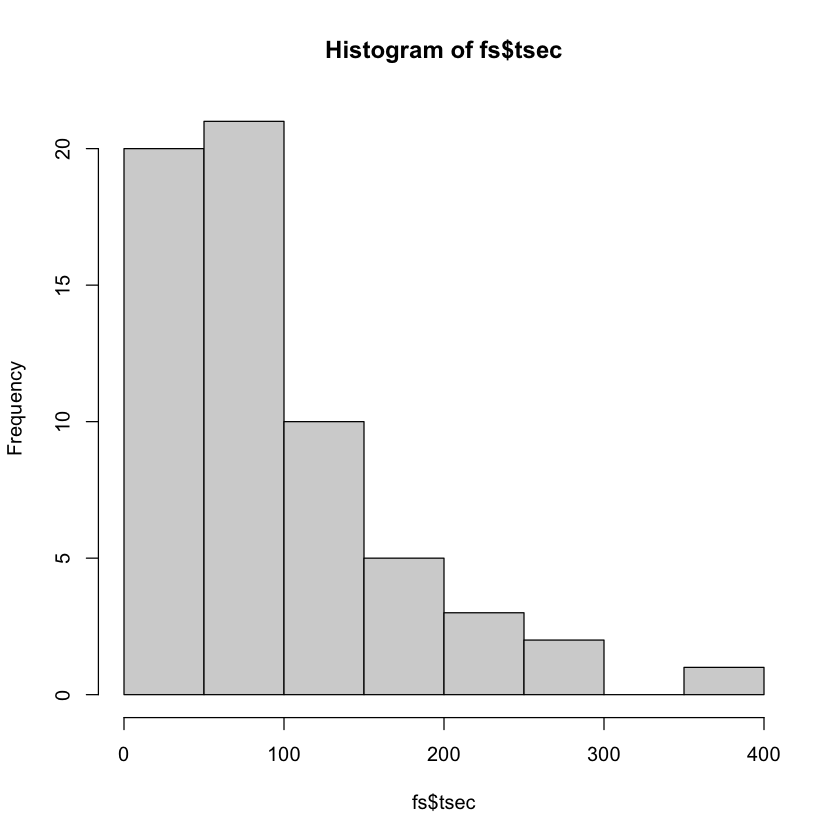

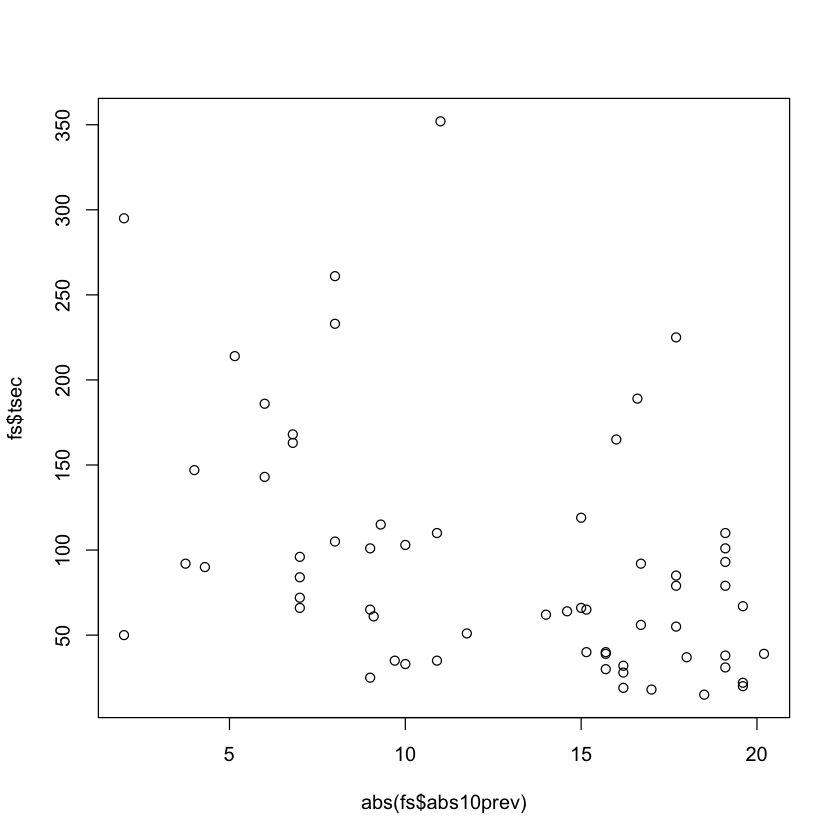

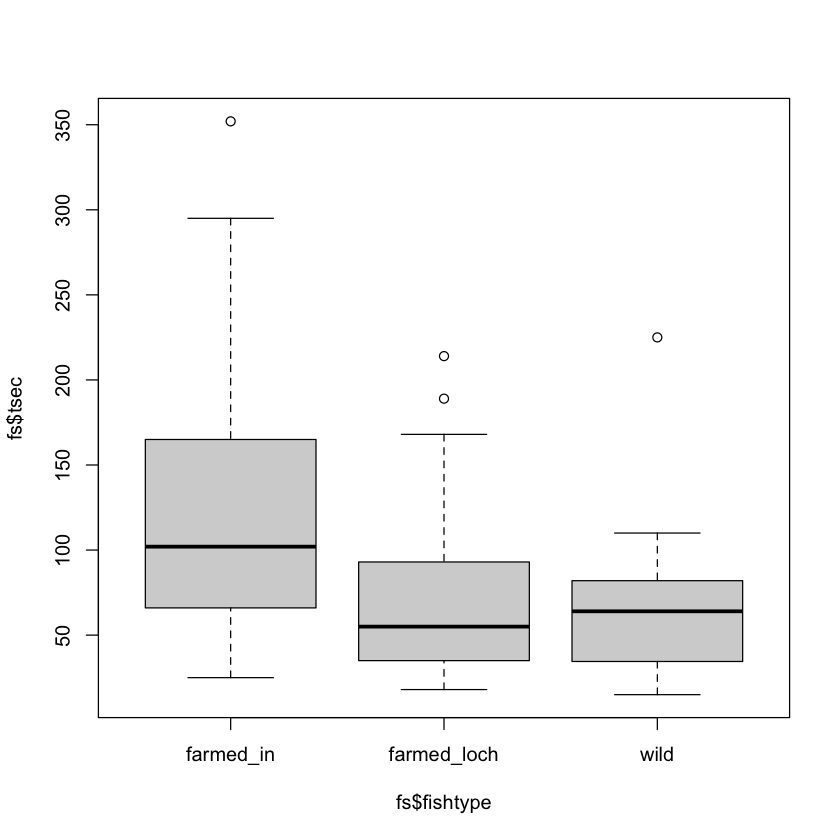

In [226]:
hist(fs$tsec) # we are modelling response time
plot(fs$tsec ~ abs(fs$abs10prev))
boxplot(fs$tsec ~ fs$fishtype)

In [228]:
#This cell helps to get group estimates of expected value and CIs

#fsx <- fs
#fsx <- subset(fs, fishtype == 'wild')
#fsx <- subset(fs, fishtype == 'farmed_loch')
fsx <- subset(fs, fishtype == 'farmed_in')

#First we fit gamma distribution directly to the absolute 10s flow 
#at the moment and point of turning to get the central estmate and confidence intervals

modeltimegauss <- glm(tsec ~ 1,family=Gamma(link='log'),fsx)

modeltimegauss$family$linkinv(modeltimegauss$coef[[1]])

cm <- modeltimegauss$family$linkinv(modeltimegauss$coef[[1]])
cup <- modeltimegauss$family$linkinv(summary(modeltimegauss)$coefficients[,1]+1.96*summary(modeltimegauss)$coefficients[,2])
cdo <- modeltimegauss$family$linkinv(summary(modeltimegauss)$coefficients[,1]-1.96*summary(modeltimegauss)$coefficients[,2])

#95% confidence limits
print(paste('estimuted mu is ', cm))
print(paste('down 95% int ', cup))
print(paste('up 95%', cdo))

[1] 128.5909

[1] "estimuted mu is  128.590909090909"
[1] "down 95% int  171.049020327262"
[1] "up 95% 96.6718305032639"


In [231]:
library(lme4)

modeltimegauss <- glmer(tsec ~ fishtype + (1 | abs10prev),family='gaussian',fs) 
summary(modeltimegauss)

Warning message in glmer(tsec ~ fishtype + (1 | abs10prev), family = "gaussian", :
“calling glmer() with family=gaussian (identity link) as a shortcut to lmer() is deprecated; please call lmer() directly”


Linear mixed model fit by REML ['lmerMod']
Formula: tsec ~ fishtype + (1 | abs10prev)
   Data: fs

REML criterion at convergence: 671.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9503 -0.4492 -0.1807  0.3318  2.5347 

Random effects:
 Groups    Name        Variance Std.Dev.
 abs10prev (Intercept) 1938     44.02   
 Residual              2984     54.63   
Number of obs: 62, groups:  abs10prev, 33

Fixed effects:
                    Estimate Std. Error t value
(Intercept)           135.81      18.16   7.480
fishtypefarmed_loch   -62.42      23.78  -2.625
fishtypewild          -58.59      26.51  -2.210

Correlation of Fixed Effects:
            (Intr) fshty_
fshtypfrmd_ -0.764       
fishtypewld -0.685  0.638

In [234]:
modeltime3 <- glmer(tsec ~ fishtype + (1 | abs10prev),fs,family='Gamma',nAGQ = 0) 
# I had some model convergence error:
#https://stats.stackexchange.com/questions/412185/model-is-nearly-unidentifiable-very-large-eigenvalue
#NAGQ: from docs: A value of zero uses a faster but less exact form of parameter estimation for GLMMs by optimizing 
#the random effects and the fixed-effects coefficients in the penalized iteratively reweighted least squares step. 

summary(modeltime3)
anova(modeltime3)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Gamma  ( inverse )
Formula: tsec ~ fishtype + (1 | abs10prev)
   Data: fs

     AIC      BIC   logLik deviance df.resid 
   658.1    668.7   -324.0    648.1       57 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5015 -0.7898 -0.2506  0.4620  2.4272 

Random effects:
 Groups    Name        Variance  Std.Dev.
 abs10prev (Intercept) 2.772e-05 0.005265
 Residual              2.288e-01 0.478291
Number of obs: 62, groups:  abs10prev, 33

Fixed effects:
                    Estimate Std. Error t value Pr(>|z|)    
(Intercept)         0.008492   0.001832   4.636 3.55e-06 ***
fishtypefarmed_loch 0.006691   0.002590   2.583   0.0098 ** 
fishtypewild        0.005665   0.003020   1.876   0.0607 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fshty_
fshtypfrmd_ -0.707       
fishtypewld

,npar,Sum Sq,Mean Sq,F value
,<int>,<dbl>,<dbl>,<dbl>
fishtype,2,1.576337,0.7881683,3.445353


## Absolute flow 10second average as an explanatory variable

For one of the flow conditions it is a little bit different but doesn't really

In [237]:
fs$abs10 <- fs$abs10 + 0.00001 # there are some values equal 0 we cannto model gamm with that so we shift all ever so slightly

In [238]:
fsx <- fs
#fsx <- subset(fs, fishtype == 'wild')
#fsx <- subset(fs, fishtype == 'farmed_loch')
#fsx <- subset(fs, fishtype == 'farmed_in')

#First we fit gamma distribution directly to the absolute 10s flow 
#at the moment and point of turning to get the central estmate and confidence intervals

modeltimegauss <- glm(abs10 ~ 1,fsx,family=Gamma(link="log"))
modeltimegauss$family$linkinv(modeltimegauss$coef[[1]])

cm <- modeltimegauss$family$linkinv(modeltimegauss$coef[[1]])
cup <- modeltimegauss$family$linkinv(summary(modeltimegauss)$coefficients[,1]+1.96*summary(modeltimegauss)$coefficients[,2])
cdo <- modeltimegauss$family$linkinv(summary(modeltimegauss)$coefficients[,1]-1.96*summary(modeltimegauss)$coefficients[,2])

#95% confidence limits
print(paste('estimuted mu is ', cm))
print(paste('down 95% int ', cup))
print(paste('up 95%', cdo))

[1] 8.941945

[1] "estimuted mu is  8.94194548404267"
[1] "down 95% int  10.3721658199828"
[1] "up 95% 7.70893855992399"


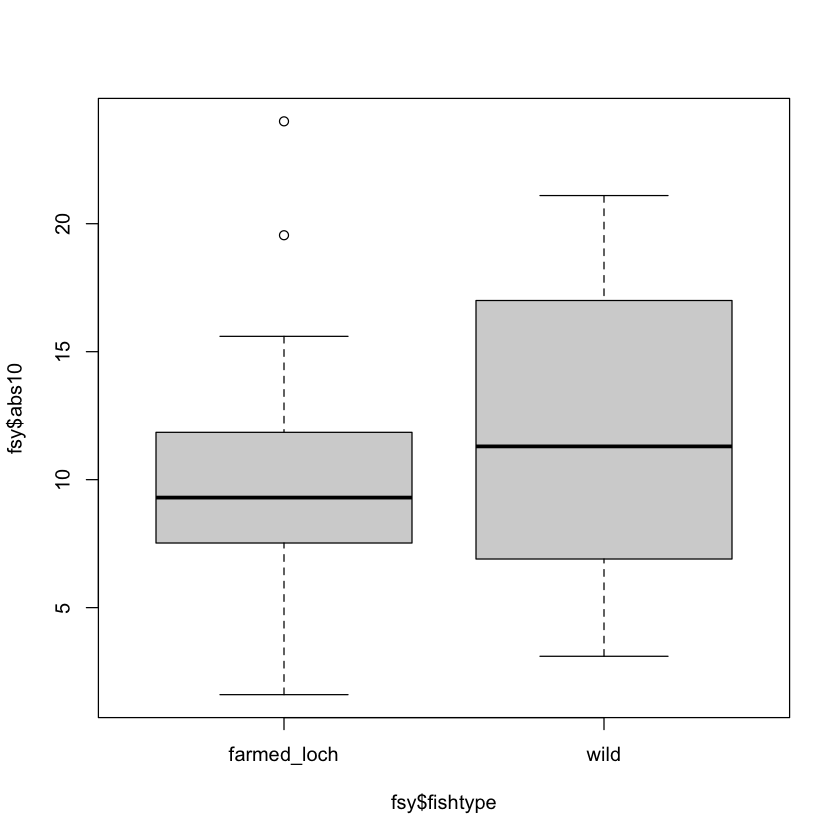

In [265]:
fsy <- subset(fs, fs == 'high')
modelflowONE <- glm(abs10 ~ fishtype + abs10prev + abs10prev * fishtype,fsy,family=Gamma(link="log"))
boxplot(fsy$abs10 ~ fsy$fishtype)


In [266]:
anova(modelflowONE,test='LRT')

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,29,10.264798,NA
fishtype,1,0.2019946,28,10.062804,0.4081183
abs10prev,1,0.4320769,27,9.630727,0.2263422
fishtype:abs10prev,1,0.6217333,26,9.008994,0.1467051


In [267]:
summary(modelflowONE)


Call:
glm(formula = abs10 ~ fishtype + abs10prev + abs10prev * fishtype, 
    family = Gamma(link = "log"), data = fsy)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.27808  -0.49591  -0.03793   0.28507   0.80338  

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             3.92952    0.78996   4.974  3.6e-05 ***
fishtypewild           -1.56111    1.12959  -1.382   0.1787    
abs10prev              -0.09638    0.04558  -2.115   0.0442 *  
fishtypewild:abs10prev  0.10346    0.06658   1.554   0.1323    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.2951947)

    Null deviance: 10.265  on 29  degrees of freedom
Residual deviance:  9.009  on 26  degrees of freedom
AIC: 194.63

Number of Fisher Scoring iterations: 6


In [269]:
str(fsy)

'data.frame':	30 obs. of  38 variables:
 $ fishname      : chr  "fish84" "fish86" "fish87" "fish88" ...
 $ fs            : chr  "high" "high" "high" "high" ...
 $ fishdate      : chr  "27/03/2021" "27/03/2021" "27/03/2021" "27/03/2021" ...
 $ time_flow     : chr  "10:35:41" "11:32:15" "11:59:02" "12:33:10" ...
 $ time_react    : chr  "10:36:16" "11:32:35" "11:59:40" "12:33:28" ...
 $ tdiff         : chr  "00:00:35" "00:00:20" "00:00:38" "00:00:18" ...
 $ info          : chr  "dir_change" "dir_change" "dir_change" "dir_change" ...
 $ info_other    : chr  "dir change" "dir change" "dir change" "dir change" ...
 $ direction     : chr  "clock" "clock" "counter" "clock" ...
 $ stable10prev  : num  10.9 19.6 19.1 17 19.6 ...
 $ change10      : num  -10.3 7 -3.4 8.4 3.9 -8.05 -9.5 -15.6 24 -13 ...
 $ stable10after : num  -14.2 -15.3 -7.1 -21.6 -14.3 -9.6 -10.8 -21.1 23.2 -12.9 ...
 $ fishtype      : chr  "farmed_loch" "farmed_loch" "farmed_loch" "farmed_loch" ...
 $ loc_name      : chr  "fish


Call:
glm(formula = abs10 ~ fishtype + abs10prev + abs10prev * fishtype, 
    family = Gamma(link = "log"), data = fs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0103  -0.4237  -0.0194   0.2137   1.2545  

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.59813    0.30867   5.177 3.16e-06 ***
fishtypefarmed_loch            0.60936    0.45037   1.353    0.181    
fishtypewild                   0.77028    0.91053   0.846    0.401    
abs10prev                      0.04403    0.03279   1.343    0.185    
fishtypefarmed_loch:abs10prev -0.04853    0.03940  -1.232    0.223    
fishtypewild:abs10prev        -0.03695    0.06104  -0.605    0.547    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.3322538)

    Null deviance: 47.875  on 61  degrees of freedom
Residual deviance: 45.016  on 56  degrees of freedom
AIC: 401.27

Numb

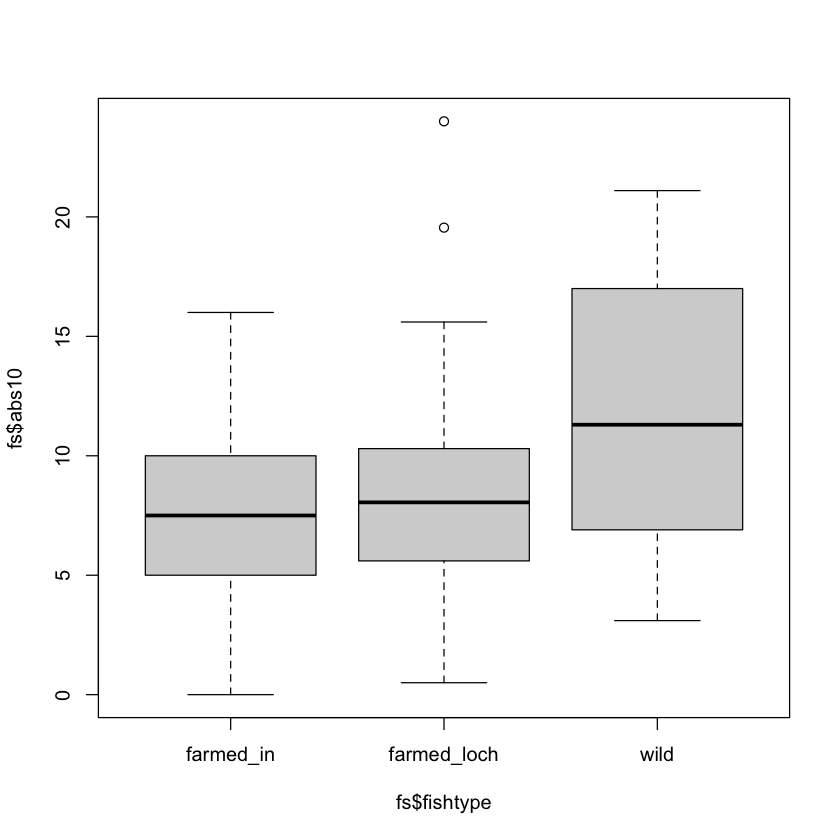

In [252]:
#boxplot(fs$abs10 ~ fs$fsdir)
boxplot(fs$abs10 ~ fs$fishtype)

#modelflow <- glm(abs10 ~ fishtype + abs10prev + abs10prev * fishtype,fs,family='Gamma')#modelling as fixed effect
modelflowC <- glm(abs10 ~ fishtype + abs10prev + abs10prev * fishtype,fs,family=Gamma(link="log")
)#modelling as fixed effect
#modelflow <- glm(abs10 ~ fishtype,fs,family=Gamma(link="log"))

summary(modelflowC)

In [253]:
anova(modelflowC, test='LRT')

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,61,47.87511,NA
fishtype,2,2.31212224,59,45.56298,0.0308243
abs10prev,1,0.09644935,58,45.46654,0.5900359
fishtype:abs10prev,2,0.45060760,56,45.01593,0.5075766


In [254]:
modelflowD <- glmer(abs10 ~ fishtype + (1 | abs10prev),fs,family='Gamma')#modelling flow were holding as as random effect
summary(modelflowD)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( inverse )
Formula: abs10 ~ fishtype + (1 | abs10prev)
   Data: fs

     AIC      BIC   logLik deviance df.resid 
   399.6    410.3   -194.8    389.6       57 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.90853 -0.58253  0.00347  0.47516  2.93015 

Random effects:
 Groups    Name        Variance  Std.Dev.
 abs10prev (Intercept) 0.0001948 0.01396 
 Residual              0.2745357 0.52396 
Number of obs: 62, groups:  abs10prev, 33

Fixed effects:
                    Estimate Std. Error t value Pr(>|z|)    
(Intercept)          0.13921    0.02437   5.712 1.12e-08 ***
fishtypefarmed_loch -0.01963    0.03074  -0.639    0.523    
fishtypewild        -0.04885    0.03126  -1.563    0.118    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fshty_
fshtypfrmd_ -0.767       
fishtypewld -0.717  0.

In [255]:
anova(modelflowD,test='LRT')

Warning message in anova.merMod(modelflowD, test = "LRT"):
“additional arguments ignored: ‘test’”


,npar,Sum Sq,Mean Sq,F value
,<int>,<dbl>,<dbl>,<dbl>
fishtype,2,1.668781,0.8343904,3.039278


In [261]:
#fs$fishtypef <- relevel(factor(fs$fishtype),'wild')

modelflowB <- glm(abs10 ~ fishtype,fs,family=Gamma(link="log"))
anova(modelflowB,test='LRT')
summary(modelflowB)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,61,47.87511,NA
fishtype,2,2.312122,59,45.56298,0.02774136



Call:
glm(formula = abs10 ~ fishtype, family = Gamma(link = "log"), 
    data = fs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0007  -0.3902  -0.0512   0.2269   1.2469  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.9904     0.1211  16.439   <2e-16 ***
fishtypefarmed_loch   0.1542     0.1660   0.929   0.3568    
fishtypewild          0.4943     0.1902   2.599   0.0118 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.3224869)

    Null deviance: 47.875  on 61  degrees of freedom
Residual deviance: 45.563  on 59  degrees of freedom
AIC: 396.1

Number of Fisher Scoring iterations: 6


## Flow as a fraction of stable flow when holding as an explanatory variable

no - the following is not necessary as we are modelling flow in the holding position before a swith as an explanatory variable

In [243]:
fs$asfractprev10 <- abs(fs$asfractprev10) + 0.00001

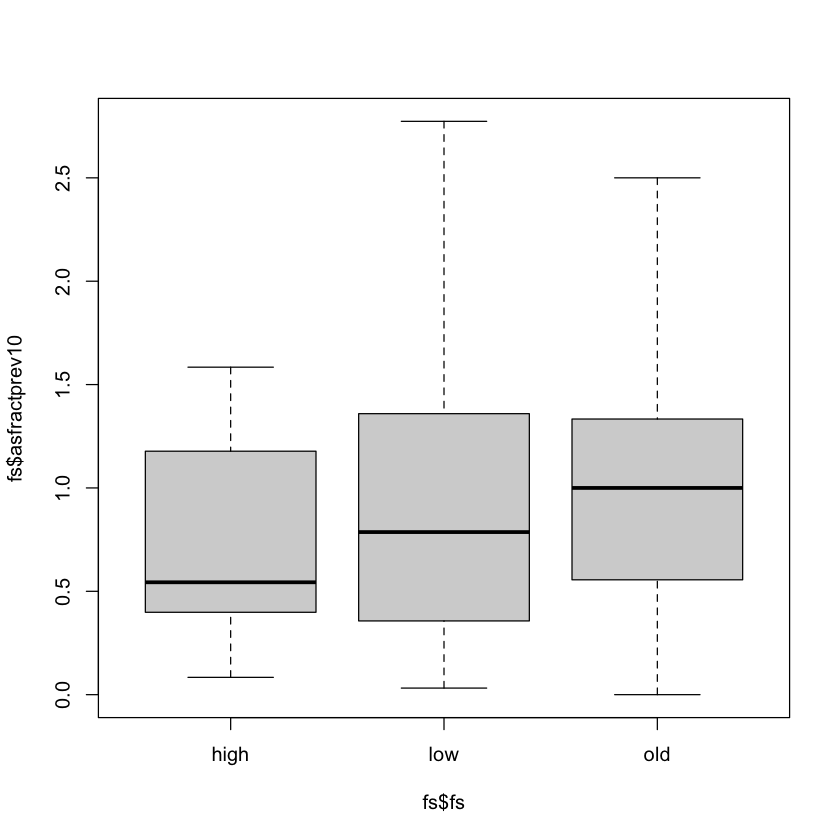

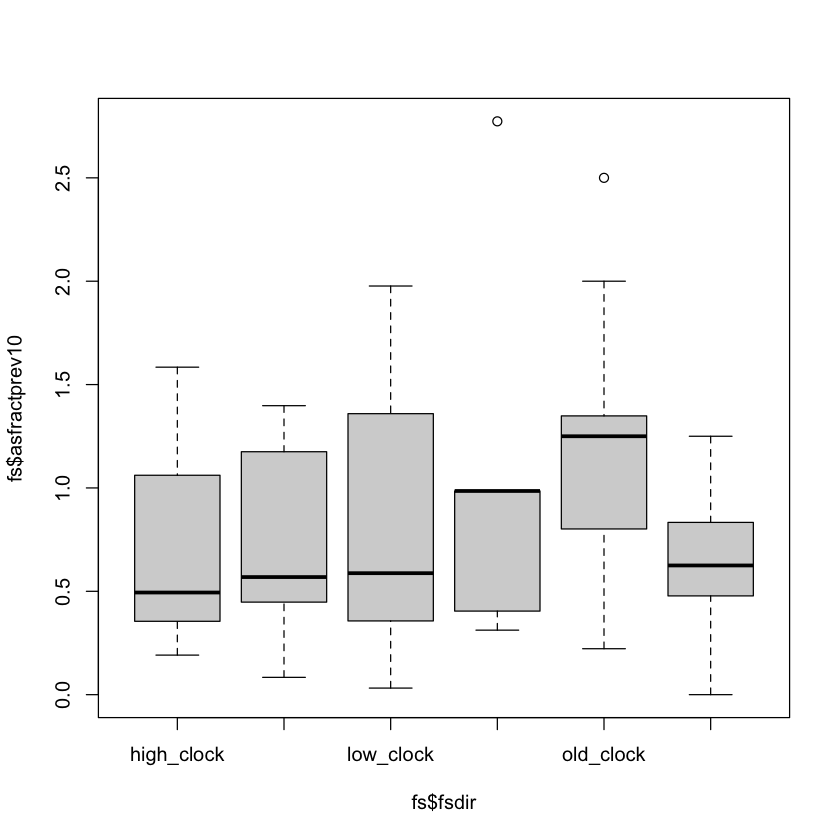


Call:
glm(formula = asfractprev10 ~ fishtype, family = "Gamma", data = fs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.5844  -0.6055  -0.1701   0.3257   1.5958  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.0044     0.1475   6.808 5.72e-09 ***
fishtypefarmed_loch   0.2707     0.2294   1.180    0.243    
fishtypewild          0.3054     0.2758   1.107    0.273    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.4746829)

    Null deviance: 51.962  on 61  degrees of freedom
Residual deviance: 51.059  on 59  degrees of freedom
AIC: 108.75

Number of Fisher Scoring iterations: 6


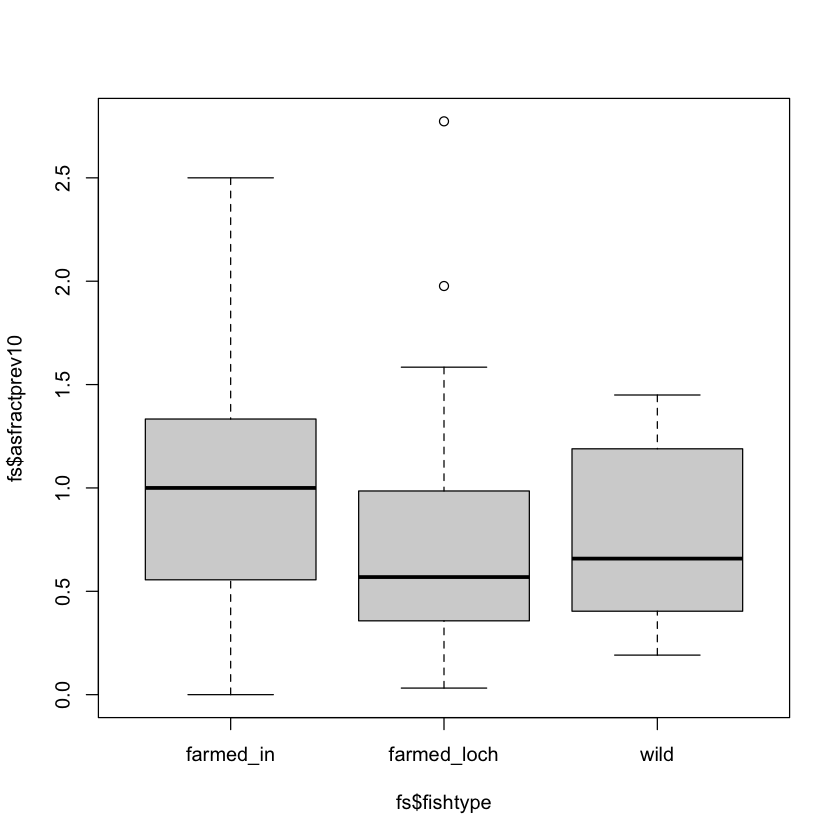

In [244]:
boxplot(fs$asfractprev10 ~ fs$fs)
boxplot(fs$asfractprev10 ~ fs$fsdir)
boxplot(fs$asfractprev10 ~ fs$fishtype)

modelflowasfract <- glm(asfractprev10 ~ fishtype,fs,family='Gamma')
summary(modelflowasfract)

#### Re-tuning the flume before taking "high" flow measurmenets

Before I took measurements of "high" flow conditions (The same pump power as "low" but without that many grids put into the flume) the pump died. 
I had to re-tune the flow to achieve similar flows with a new pump which we bought in the summer.
Re-tuning meant that I used 5 points in the experimental arena to get values of flow as close as possible to the ones measured in Spring.
It was the same model and all the inflows were the same, however we expected difference in the power just on account of engine wear and tear in the old pump.
The following shows that the difference of stable flow in 7 points in the experimental arena (14 measurements as there are two direction of flow), 
is not significantly diffrent than zero

'data.frame':	14 obs. of  3 variables:
 $ mar.low: num  17 16 6 13 11 15 14 8.5 11 8 ...
 $ oct.low: num  15.7 14.3 4.3 11.9 11.9 ...
 $ diff   : num  1.3 1.7 1.7 1.05 -0.889 ...



Call:
glm(formula = diff ~ 1, family = "gaussian", data = flowtune)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4044  -1.3502   0.0651   1.1290   6.1790  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.5710     0.6829   0.836    0.418

(Dispersion parameter for gaussian family taken to be 6.52974)

    Null deviance: 84.887  on 13  degrees of freedom
Residual deviance: 84.887  on 13  degrees of freedom
AIC: 68.962

Number of Fisher Scoring iterations: 2


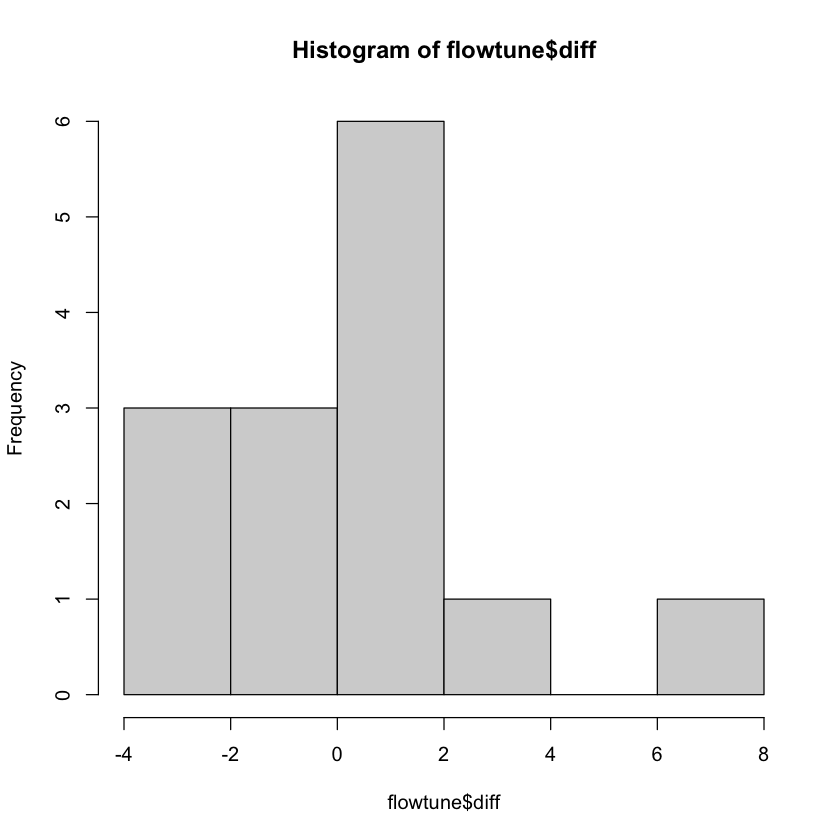

In [199]:
flowtune <- read.csv('./input/flowtune.csv')
str(flowtune)
hist(flowtune$diff)
modeltuneflow <- glm(diff ~ 1,flowtune,family='gaussian')
summary(modeltuneflow)